In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wsdm-cup-multilingual-chatbot-arena/sample_submission.csv
/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet
/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-preprocess/2/saved_model.pb
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-preprocess/2/keras_metadata.pb
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-preprocess/2/assets/cased_vocab.txt
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-preprocess/2/variables/variables.index
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-preprocess/2/variables/variables.data-00000-of-00001
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-base/1/saved_model.pb
/kaggle/input/universal-sentence-encoder/tensorflow2/cmlm-multilingual-base/1/assets/bert_vocab_500k.external.111lang.txt
/kaggle/input/universal-sentence-encoder/ten

In [2]:
import warnings
warnings.simplefilter('ignore')

from IPython.display import display, clear_output

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier, early_stopping

from tqdm import tqdm

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

In [3]:
train = pd.read_parquet('../input/wsdm-cup-multilingual-chatbot-arena/train.parquet')
test = pd.read_parquet('../input/wsdm-cup-multilingual-chatbot-arena/test.parquet')

In [5]:
train.head(5)

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,Please be boring,"Alright, I'll be as boring as possible.\n\nTod...","Understood. Here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English


In [6]:
class CFG:
    BATCH_SIZE = 32
    pca_dimensions = 256
    N_FOLDS = 5

In [7]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/cmlm-multilingual-preprocess/2")
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/cmlm-multilingual-base/1")


def embed_text(df: pd.DataFrame, col:str):
    inputs = preprocessor(df[col])
    embeddings = encoder(inputs)

    return embeddings['pooled_output'].numpy()


def create_embeddings(input_df: pd.DataFrame):
    prompt_ary = np.zeros((len(input_df), 768))
    res_a_ary = np.zeros((len(input_df), 768))
    res_b_ary = np.zeros((len(input_df), 768))

    for i in tqdm(range(0, len(input_df), CFG.BATCH_SIZE)):
        batch = input_df[i: i + CFG.BATCH_SIZE]
        prompt_ary[i: i + len(batch)] = embed_text(batch, 'prompt')
        res_a_ary[i: i + len(batch)] = embed_text(batch, 'response_a')
        res_b_ary[i: i + len(batch)] = embed_text(batch, 'response_b')

    return prompt_ary, res_a_ary, res_b_ary

In [8]:
%%time
prompt_train, res_a_train, res_b_train = create_embeddings(train)

100%|██████████| 1514/1514 [29:47<00:00,  1.18s/it]

CPU times: user 34min 3s, sys: 1min 20s, total: 35min 24s
Wall time: 29min 47s


In [9]:
%%time
prompt_test, res_a_test, res_b_test = create_embeddings(test)

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

CPU times: user 914 ms, sys: 10 ms, total: 924 ms
Wall time: 891 ms


In [10]:
tot_train = np.concatenate((prompt_train, res_a_train, res_b_train))

pca = PCA(n_components=CFG.pca_dimensions)
vec_pca = pca.fit_transform(tot_train)

# prompt vectors are used only in calculating cosine_similarity 
p_train = vec_pca[:len(train)]
a_train = vec_pca[len(train):len(train) + len(train)]
b_train = vec_pca[len(train) + len(train):]

p_test = pca.transform(prompt_test)
a_test = pca.transform(res_a_test)
b_test = pca.transform(res_b_test)

pca_a_train = pd.DataFrame(a_train).rename(
    columns={i: f'res_a_{i}' for i in range(CFG.pca_dimensions)})
pca_b_train = pd.DataFrame(b_train).rename(
    columns={i: f'res_b_{i}' for i in range(CFG.pca_dimensions)})
pca_a_test = pd.DataFrame(a_test).rename(
    columns={i: f'res_a_{i}' for i in range(CFG.pca_dimensions)})
pca_b_test = pd.DataFrame(b_test).rename(
    columns={i: f'res_b_{i}' for i in range(CFG.pca_dimensions)})

diff_train = pd.DataFrame(a_train - b_train).rename(
    columns={i: 'diff_'+str(i) for i in range(CFG.pca_dimensions)})
diff_test = pd.DataFrame(a_test - b_test).rename(
    columns={i: 'diff_'+str(i) for i in range(CFG.pca_dimensions)})

pca_train = pd.concat([pca_a_train, pca_b_train, diff_train], axis=1)
pca_test = pd.concat([pca_a_test, pca_b_test, diff_test], axis=1)

def calc_cosine_similarity(p_vectors, a_vectors, b_vectors):
    p_norms = np.linalg.norm(p_vectors, axis=1)
    a_norms = np.linalg.norm(a_vectors, axis=1)
    b_norms = np.linalg.norm(b_vectors, axis=1)
    
    pa_products = np.sum(p_vectors * a_vectors, axis=1)
    pb_products = np.sum(p_vectors * b_vectors, axis=1)
    
    p_a_similarity = pa_products / (p_norms * a_norms)
    p_b_similarity = pb_products / (p_norms * b_norms)

    return p_a_similarity, p_b_similarity

p_a_train, p_b_train = calc_cosine_similarity(p_train, a_train, b_train)
p_a_test, p_b_test = calc_cosine_similarity(p_test, a_test, b_test)

In [12]:
def set_features(orig_df, pca_df, p_a_similarity, p_b_similarity):
    out_df = pca_df.copy()
    out_df['length_a'] = orig_df['response_a'].str.len()
    out_df['length_b'] = orig_df['response_b'].str.len()
    out_df['diff_length'] = out_df['length_a'] - out_df['length_b']
    
    out_df['p_a_similarity'] = p_a_similarity
    out_df['p_b_similarity'] = p_b_similarity
    
    return out_df

In [13]:
x = set_features(train, pca_train, p_a_train, p_b_train)
test_x = set_features(test, pca_test, p_a_test, p_b_test)

y = train['winner'].map({'model_a':0, 'model_b':1})
stratify = train['winner'] + '_' + train['language']

In [14]:
oof = np.zeros(len(train))
pred = np.zeros(len(test))
fi_df = pd.DataFrame()

oofs = []
iters = []

skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=0)

model = LGBMClassifier(
    n_estimators=1000,
    device_type='gpu',
    max_depth=5,
    colsample_bytree=0.5,
    reg_alpha=0.05,
    learning_rate=0.04,
    importance_type='gain',
    random_state=0,
    verbose=-1
)

for i, (train_idx, valid_idx) in enumerate(skf.split(x, stratify)):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]

    model.fit(x_train, y_train,
              eval_set=(x_valid, y_valid),
              callbacks=[early_stopping(stopping_rounds=100, verbose=False)])

    oof[valid_idx] = model.predict_proba(x_valid)[:, 1]
    pred += model.predict_proba(test_x)[:, 1] / CFG.N_FOLDS

    fi_df = pd.concat([fi_df,
                       pd.DataFrame({'fold':i, 'feature': x_train.columns, 'FI':model.feature_importances_})])

    fold_accuracy = accuracy_score(y_valid, np.where(oof[valid_idx]>0.5, 1, 0))
    oofs.append(fold_accuracy)
    iters.append(model.best_iteration_)
    clear_output()

_df = pd.DataFrame({'accuracy':oofs, 'best_iterations_':iters})
display(_df)

tot_accuracy = accuracy_score(y, np.where(oof > 0.5, 1, 0))
print(f'Total Accuracy: {tot_accuracy: .4f}')

,accuracy,best_iterations_
0,0.604253,302
1,0.610549,408
2,0.603633,442
3,0.601569,333
4,0.609890,376


Total Accuracy:  0.6060


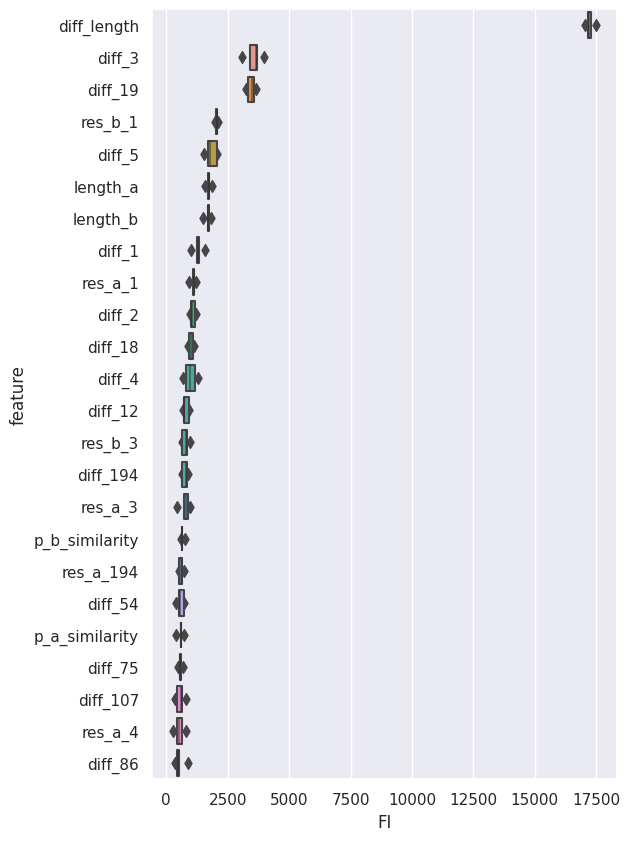

In [15]:
_order = fi_df.groupby('feature')['FI'].mean().sort_values(ascending=False)[:24].index

fig, ax = plt.subplots(figsize=(6,10))
sns.boxenplot(y='feature', x='FI', data=fi_df[fi_df['feature'].isin(_order)], orient='h', order=_order, ax=ax);

In [ ]:
sub_df = pd.DataFrame({'id':test['id'], 'winner':np.where(pred<0.5, 'model_a', 'model_b')})
sub_df.to_csv('submission.csv', index=False)

sub_df